# ヘブ/反ヘブ則とMDS
Hebbian/anti-hebbian ruleとMDSの関係．

ISOMAPに近づけないと話にならない

In [1]:
using PyPlot, Random, Distributions, LinearAlgebra, FFTW
rc("axes.spines", top=false, right=false)
rc("font", family="Meiryo")

In [2]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html
function make_swiss_roll(;n_samples=1500, σ_noise=0.05)
    t = 1.5 * pi * (1 .+ 2 * rand(n_samples))
    y = 21 * rand(n_samples);
    x = t .* cos.(t)
    z = t .* sin.(t);
    X = [x y z]
    X += σ_noise * randn(n_samples, 3)
    return X, t
end

make_swiss_roll (generic function with 1 method)

In [3]:
function make_s_curve(;n_samples=1500, σ_noise=0.05)
    t = 3 * pi * (rand(n_samples) .- 0.5)
    x = sin.(t)
    y = 2.0 * rand(n_samples)
    z = sign.(t) .* (cos.(t) .- 1)
    X = [x y z]
    X += σ_noise * randn(n_samples, 3);
    return X, t
end

make_s_curve (generic function with 1 method)

In [4]:
X_s, t_s = make_s_curve(n_samples=1500, σ_noise=0.05);

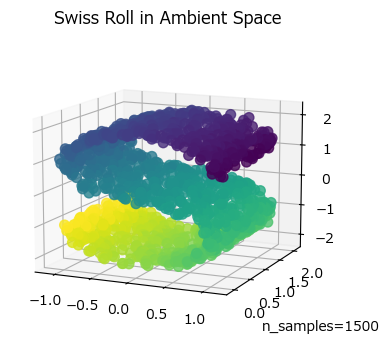

In [5]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_s[:, 1], X_s[:, 2], X_s[:, 3], c=t_s, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)
fig.tight_layout()

In [6]:
X_sr, t_sr = make_swiss_roll(n_samples=1500, σ_noise=0.05);

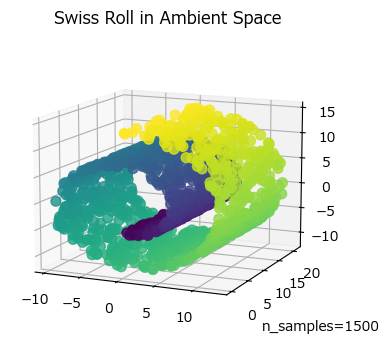

In [7]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_sr[:, 1], X_sr[:, 2], X_sr[:, 3], c=t_sr, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)
fig.tight_layout()

In [8]:
#X = (X .- mean(X, dims=2)) ./ std(X, dims=2); # normalization

In [9]:
"""
using RDatasets
#https://juliastats.org/MultivariateStats.jl/dev/mds/
## load iris dataset
iris = dataset("datasets", "iris")

# take half of the dataset
X = Matrix(iris[:,1:4])'
X_labels = Vector(iris[:,5])
#X = Matrix(iris[1:2:end,1:4])'
#X_labels = Vector(iris[1:2:end,5])
X = (X .- mean(X, dims=2)) ./ std(X, dims=2); # normalization
"""

"using RDatasets\n#https://juliastats.org/MultivariateStats.jl/dev/mds/\n## load iris dataset\niris = dataset(\"datasets\", \"iris\")\n\n# take half of the dataset\nX = Matrix(iris[:,1:4])'\nX_labels = Vector(iris[:,5])\n#X = Matrix(iris[1:2:end,1:4])'\n#X_labels = Vector(iris[1:2:end,5])\nX = (X .- mean(X, dims=2)) ./ std(X, dims=2); # normalization\n"

In [10]:
using MultivariateStats

In [32]:
#X = X_sr'
X = X_s'
X = (X .- mean(X, dims=2)) #./ std(X, dims=2); # normalization
#X = X_sr'

3×1500 Matrix{Float64}:
 -0.419843   -1.02991    0.138754  …  -1.06556   -0.406902   -0.279161
  0.0378512  -0.525446   0.657909      0.456789   0.872712   -0.405321
 -1.96171    -1.01729   -1.87347       1.24828    0.0831822   0.027107

In [33]:
M = fit(MDS, X; maxoutdim=2, distances=false)

Classical MDS(indim = 3, outdim = 2)

In [34]:
Y = predict(M)

2×1500 Matrix{Float64}:
  1.93276    0.940263  1.89294     …  -1.30031   -0.0879864  -0.0533266
 -0.538598  -1.07681   0.00941301     -0.998607  -0.421758   -0.267291

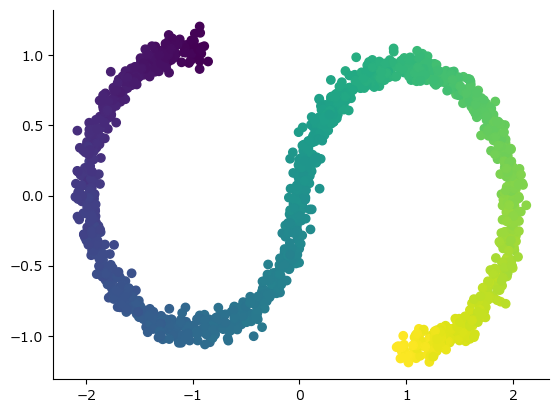

PyObject <matplotlib.collections.PathCollection object at 0x00000225998731A0>

In [36]:
scatter(Y[1, :], Y[2, :], c=t_s)
#scatter(Y[1, :], Y[2, :], c=t_sr)

In [37]:
num_random = 10

10

In [45]:
η0=0.001
τ=1
n_iter=3000
# offline PSP
input_dim, N = size(X)
output_dim = 2;

U = eigen(X * X').vectors
U_ = U[:, 1:output_dim]
UU_ = U_ * U_'
U_norm = norm(UU_, 2);

In [46]:
#loss_master = 1e6
#FF = zeros(output_dim, input_dim)
#for j in 1:num_random
#    println(j)
loss_arr = zeros(n_iter)
Random.seed!(98) #5
W = randn(output_dim, input_dim) * 1
M = I(output_dim)
F = M \ W

for i in 1:n_iter
    η = η0
    #η = η0 / (1 + i)
    # compute fixed point of output activity
    Y = F * X;
    
    # update weights
    W = W + η * (Y * X'/N - W) #+ randn(size(W))
    #W = W + 2η * (Y * X'/N - W) #+ randn(size(W))
    M = M + η/τ * (Y * Y'/N - M)  #+ randn(size(M)) # PSP
    #M += η/τ * (Y * Y'/N - I) # PSW
    
    #F = pinv(M) * W
    #M = M.*mask;
    F = M \ W
    loss = norm(F' * F - UU_, 2) /U_norm
    #loss = sum((XX - Y' * Y).^2) / N
    #print(i, loss)
    loss_arr[i] = loss
    """
    if i > 1000
        if loss_arr[i] > loss_arr[i-1]
            loss_arr = loss_arr[1:i]
            break
        end
    end
    """
end
mloss = minimum(loss_arr)
print(mloss)
Y = F * X
"""
if loss_master > mloss
        FF = F
        loss_master = mloss
    end
end
"""

#    return Y, loss_arr

1.0022977498843963

"if loss_master > mloss\n        FF = F\n        loss_master = mloss\n    end\nend\n"

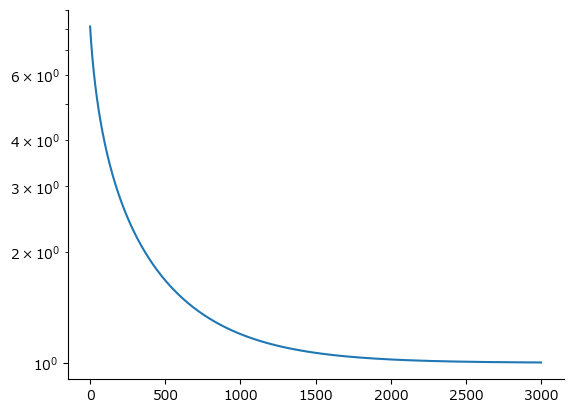

In [47]:
plot(loss_arr)
yscale("log")

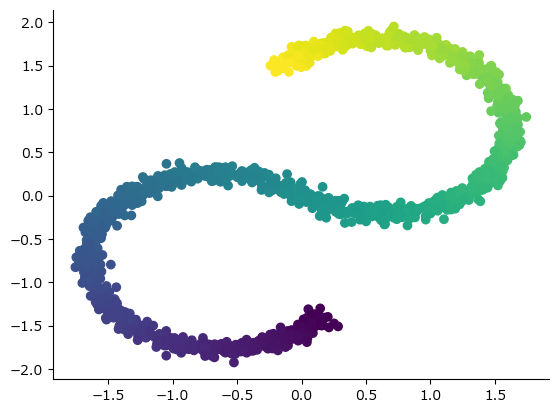

PyObject <matplotlib.collections.PathCollection object at 0x00000225A641FF20>

In [48]:
#Y = F * X;
scatter(Y[1, :], Y[2, :], c=t_s)
#scatter(Y[1, :], Y[2, :], c=t_sr)

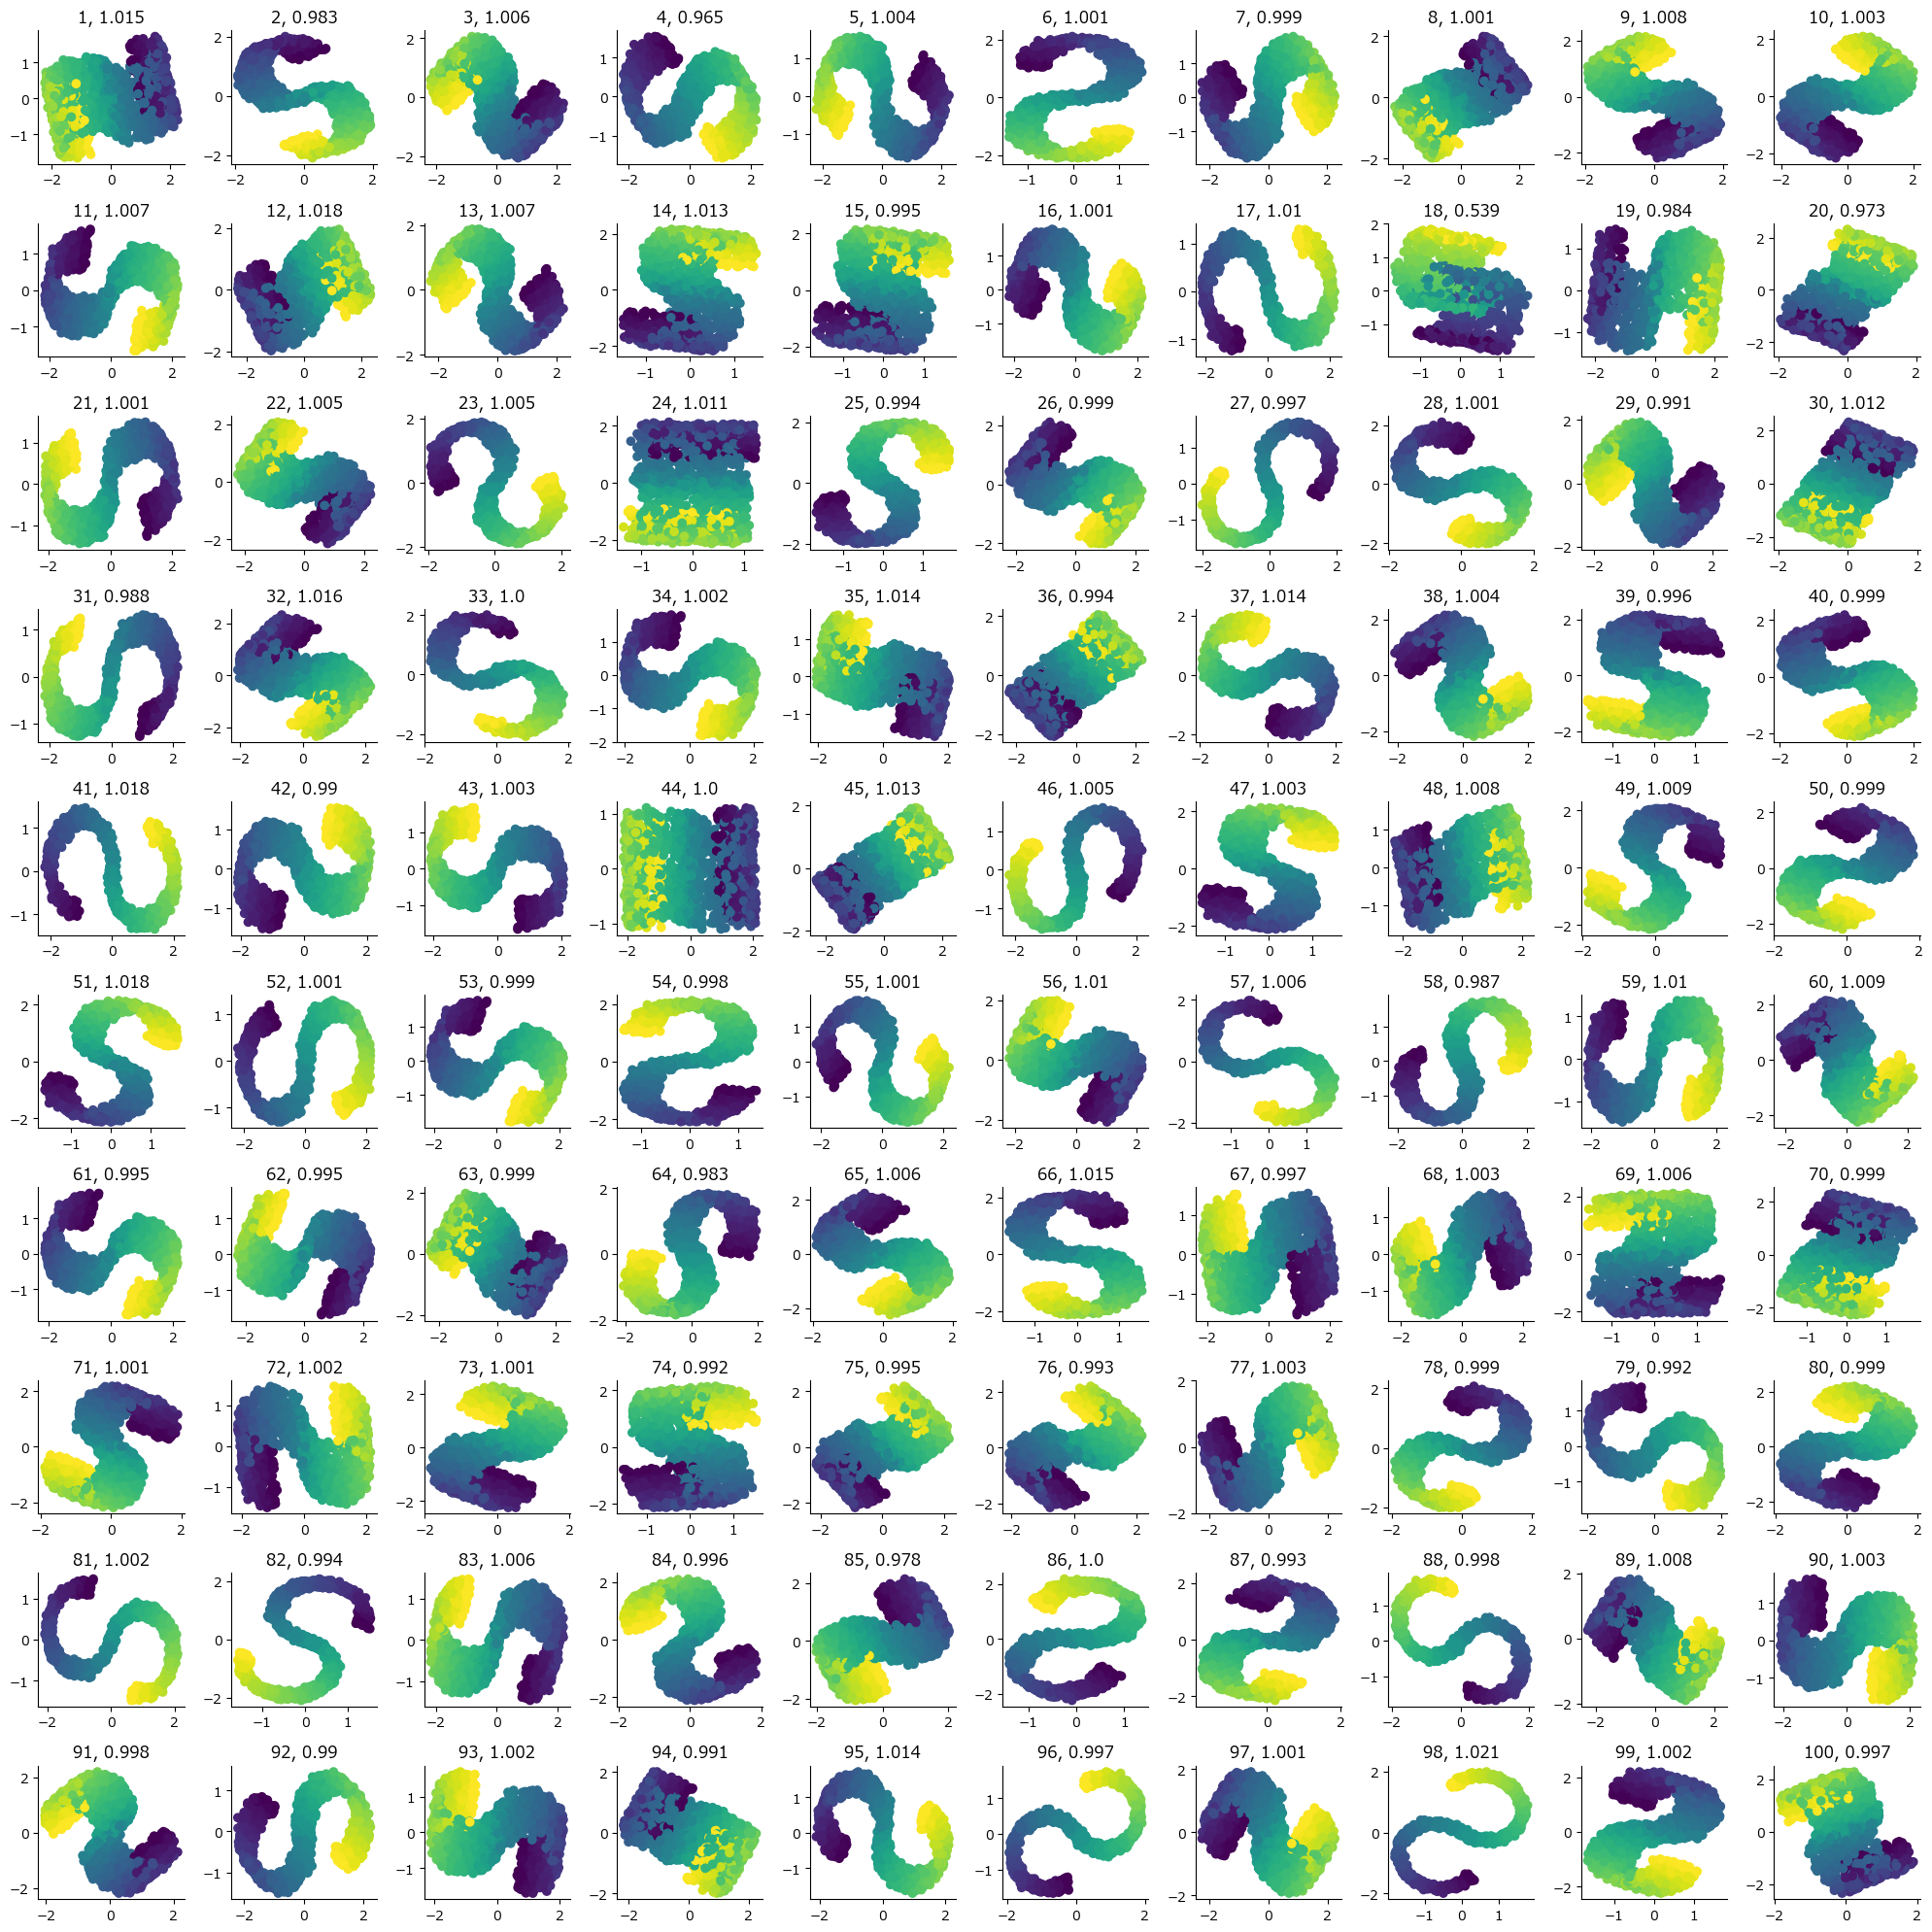

In [44]:
#loss_master = 1e6
#FF = zeros(output_dim, input_dim)
#for j in 1:num_random
#    println(j)
figure(figsize=(20,20))
for j in 1:100
    Random.seed!(j) #5
    loss_arr = zeros(n_iter)
    W = randn(output_dim, input_dim) * 1
    M = I(output_dim)
    F = M \ W
    
    for i in 1:n_iter
        η = η0
        #η = η0 / (1 + i)
        # compute fixed point of output activity
        Y = F * X;
        
        # update weights
        W = W + η * (Y * X'/N - W) #+ randn(size(W))
        #W = W + 2η * (Y * X'/N - W) #+ randn(size(W))
        M = M + η/τ * (Y * Y'/N - M)  #+ randn(size(M)) # PSP
        #M += η/τ * (Y * Y'/N - I) # PSW
        
        #F = pinv(M) * W
        #M = M.*mask;
        F = M \ W
        loss = norm(F' * F - UU_, 2) /U_norm
        #loss = sum((XX - Y' * Y).^2) / N
        #print(i, loss)
        loss_arr[i] = loss
        """
        if i > 1000
            if loss_arr[i] > loss_arr[i-1]
                loss_arr = loss_arr[1:i]
                break
            end
        end
        """
    end
    mloss = loss_arr[end]
    #mloss = minimum(loss_arr)
    #print(mloss)
    Y = F * X
    """
    if loss_master > mloss
            FF = F
            loss_master = mloss
        end
    end
    """
    subplot(10,10,j)
    title("$j, $(round(mloss, digits=3))")
    scatter(Y[1, :], Y[2, :], c=t_s)
    #scatter(Y[1, :], Y[2, :], c=t_sr)
    #show()
    #close()
end
tight_layout()

#    return Y, loss_arr

In [22]:
"""
setosa = Y[:,X_labels.=="setosa"]
versicolor = Y[:,X_labels.=="versicolor"]
virginica = Y[:,X_labels.=="virginica"]

scatter(setosa[1,:],setosa[2,:])
scatter(versicolor[1,:],versicolor[2,:])
scatter(virginica[1,:],virginica[2,:])
"""

"setosa = Y[:,X_labels.==\"setosa\"]\nversicolor = Y[:,X_labels.==\"versicolor\"]\nvirginica = Y[:,X_labels.==\"virginica\"]\n\nscatter(setosa[1,:],setosa[2,:])\nscatter(versicolor[1,:],versicolor[2,:])\nscatter(virginica[1,:],virginica[2,:])\n"

In [71]:
function HebbianPCA(X; n_components=10, η=1e-6, maxiter=200, func=identity, orthogonal=true)
    # X : n x m -> Y : n_components x m
    n = size(X)[1]
    η /= n
    X = (X .- mean(X, dims=2)) # normalization
    #X = (X .- mean(X, dims=2)) ./ std(X, dims=2) # normalization
    Y = nothing
    W = randn(n_components, n) # initialize weight
    W ./= sqrt.(sum(W.^2, dims=2)) # normalization
    for _ in 1:maxiter
        Y = func.(W * X)
        if orthogonal
            W .+= η * (Y * X' - LowerTriangular(Y * Y') * W) # Sanger's rule
        else
            W .+= η * (Y * X' - Diagonal(Y * Y') * W) # Oja's rule
        end
    end
    return Y, W
end;

In [82]:
Y2, _ = HebbianPCA(X; n_components=2, η=1e-6, maxiter=1000, func=identity, orthogonal=true)

([1.7985844960308162 0.8618587958475451 … -0.31392655129213554 -0.012751991476902005; 0.9240667475731438 0.935635695695126 … 0.7144056773211633 0.05252862524168168], [0.2032592712152116 -0.17289922464354296 -0.9637512416615901; -0.8600592883673883 0.44412608482779226 -0.27840637094711385])

In [61]:
M = fit(PCA, X; maxoutdim=2)

PCA(indim = 3, outdim = 2, principalratio = 0.877487871271317)

Pattern matrix (unstandardized loadings):
─────────────────────────
          PC1         PC2
─────────────────────────
1  -0.0847297   0.707497
2  -0.0315866  -0.0168596
3   1.38441     0.0429161
─────────────────────────

Importance of components:
─────────────────────────────────────────────
                                PC1       PC2
─────────────────────────────────────────────
SS Loadings (Eigenvalues)  1.92476   0.502677
Variance explained         0.695776  0.181711
Cumulative variance        0.695776  0.877488
Proportion explained       0.792919  0.207081
Cumulative proportion      0.792919  1.0
─────────────────────────────────────────────

In [63]:
Y = predict(M, X)

2×1500 Matrix{Float64}:
 -1.93276   -0.940263  -1.89294     …  1.30031   0.0879864  0.0533266
  0.538598   1.07681   -0.00941301     0.998607  0.421758   0.267291

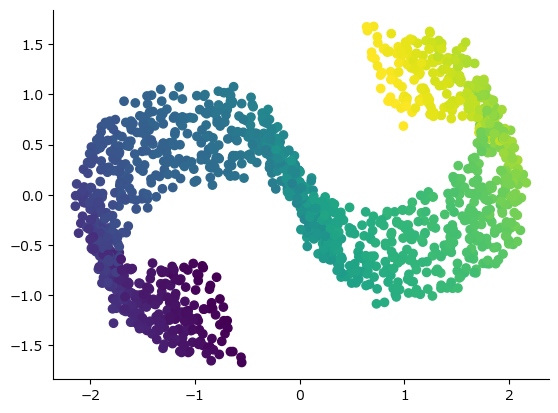

PyObject <matplotlib.collections.PathCollection object at 0x00000225A2710230>

In [83]:
#Y = F * X;
#scatter(Y[1, :], Y[2, :], c=t_s)
scatter(Y2[1, :], Y2[2, :], c=t_s)